In [33]:
# julia imports
using CSV
using DataFrames
using LaTeXStrings
using PyCall
using PyPlot
using SiriusB

In [7]:
# python imports
py"""
import sys
sys.path.append($(srcdir()))
"""

pro = pyimport("proplot")
models = pyimport("mass_models");

In [80]:
model = models.MassModel(srcdir("mass_models", "data", "model.AMES-Cond-2000.M-0.0.MKO.Vega.txt"));

In [11]:
# load the best contrast curves from each epoch
cc_1 = CSV.File(datadir("epoch_2020feb04", "processed", "2020feb04_contrast-curve_median.csv")) |> DataFrame
cc_2 = CSV.File(datadir("epoch_2020nov21", "processed", "2020nov21_contrast-curve_median.csv")) |> DataFrame
cc_3 = CSV.File(datadir("epoch_2020nov28", "processed", "2020nov28_contrast-curve_PCA-2.csv")) |> DataFrame;

In [27]:
parallax = 376.6801e-3 # arcseconds
pxscale = 0.01 # arcseconds/px
auscale = pxscale / parallax # AU/px
age = 225; # Myr

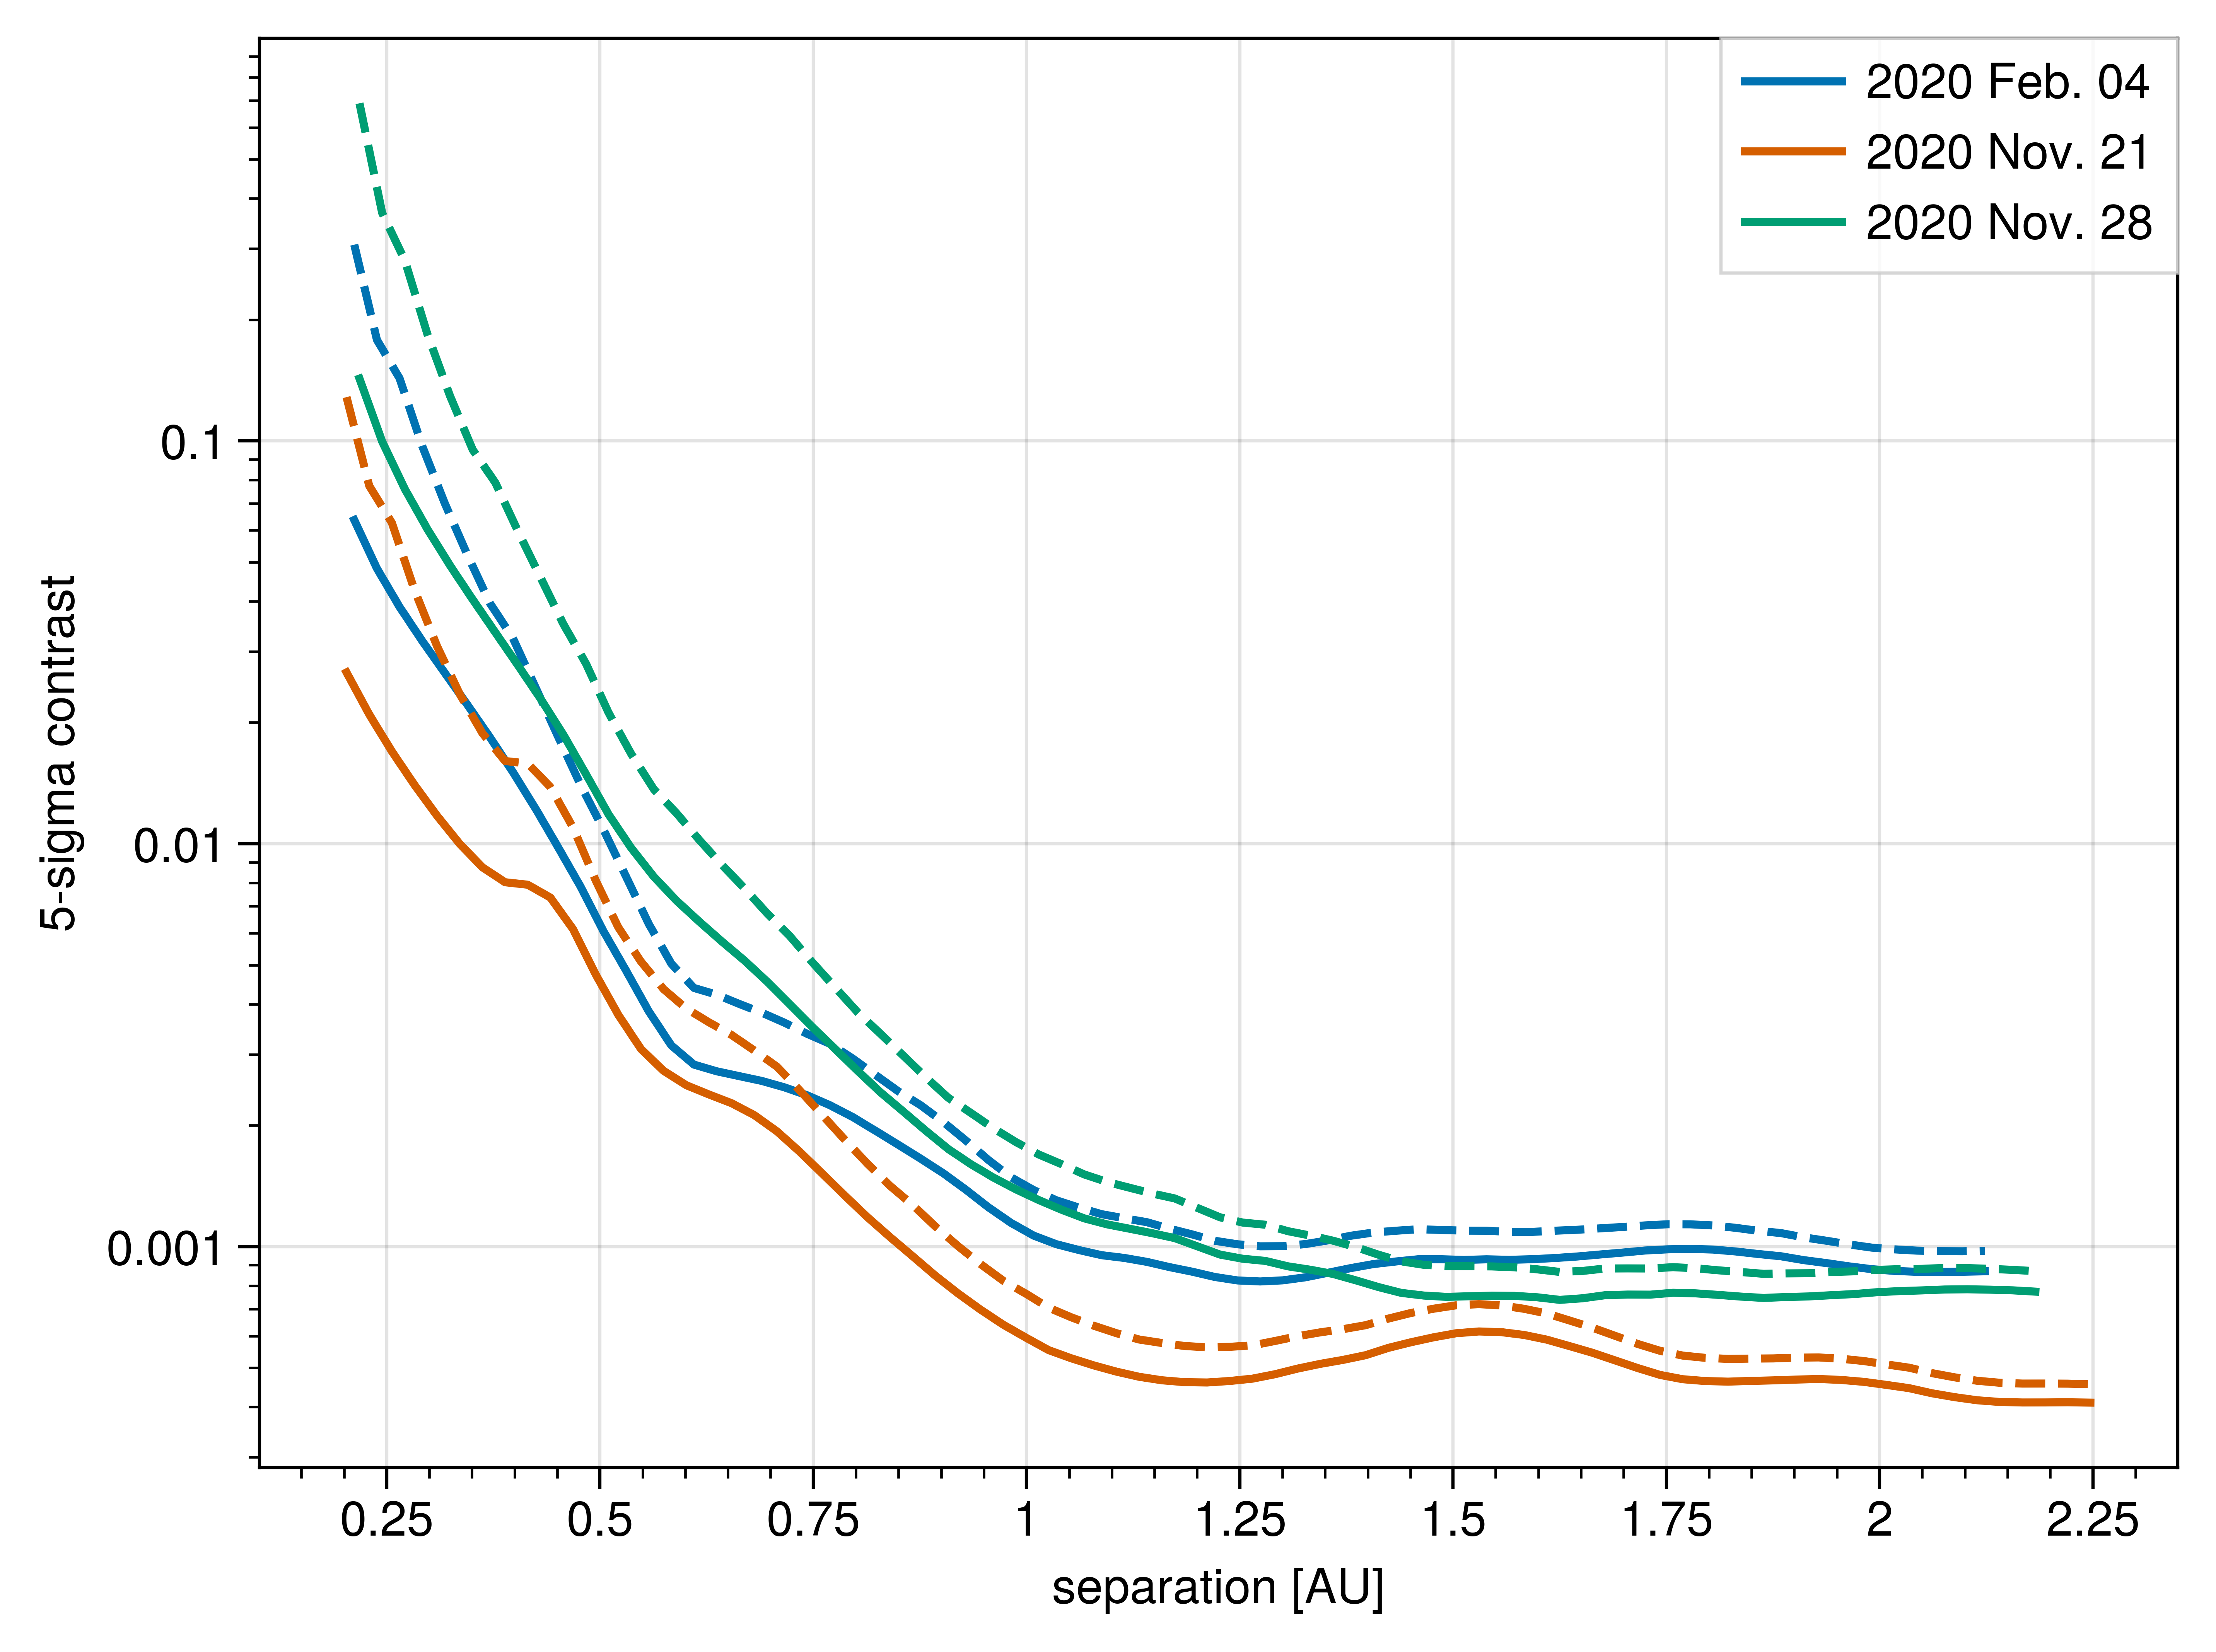

In [25]:
plot(cc_1.distance .* auscale, cc_1.contrast, color="C0", label="2020 Feb. 04")
plot(cc_1.distance .* auscale, cc_1.contrast_corr, color="C0", linestyle="--")

plot(cc_2.distance .* auscale, cc_2.contrast, color="C1", label="2020 Nov. 21")
plot(cc_2.distance .* auscale, cc_2.contrast_corr, color="C1", linestyle="--")

plot(cc_3.distance .* auscale, cc_3.contrast, color="C2", label="2020 Nov. 28")
plot(cc_3.distance .* auscale, cc_3.contrast_corr, color="C2", linestyle="--")

yscale("log")
xlabel("separation [AU]")
ylabel("5-sigma contrast")
legend();

In [163]:
1e-3, 10^(-3.5), 1e-4

(0.001, 0.00031622776601683794, 0.0001)

In [56]:
contrast_to_dmag(contrast) = -2.5 * log10(contrast)

contrast_to_dmag (generic function with 1 method)

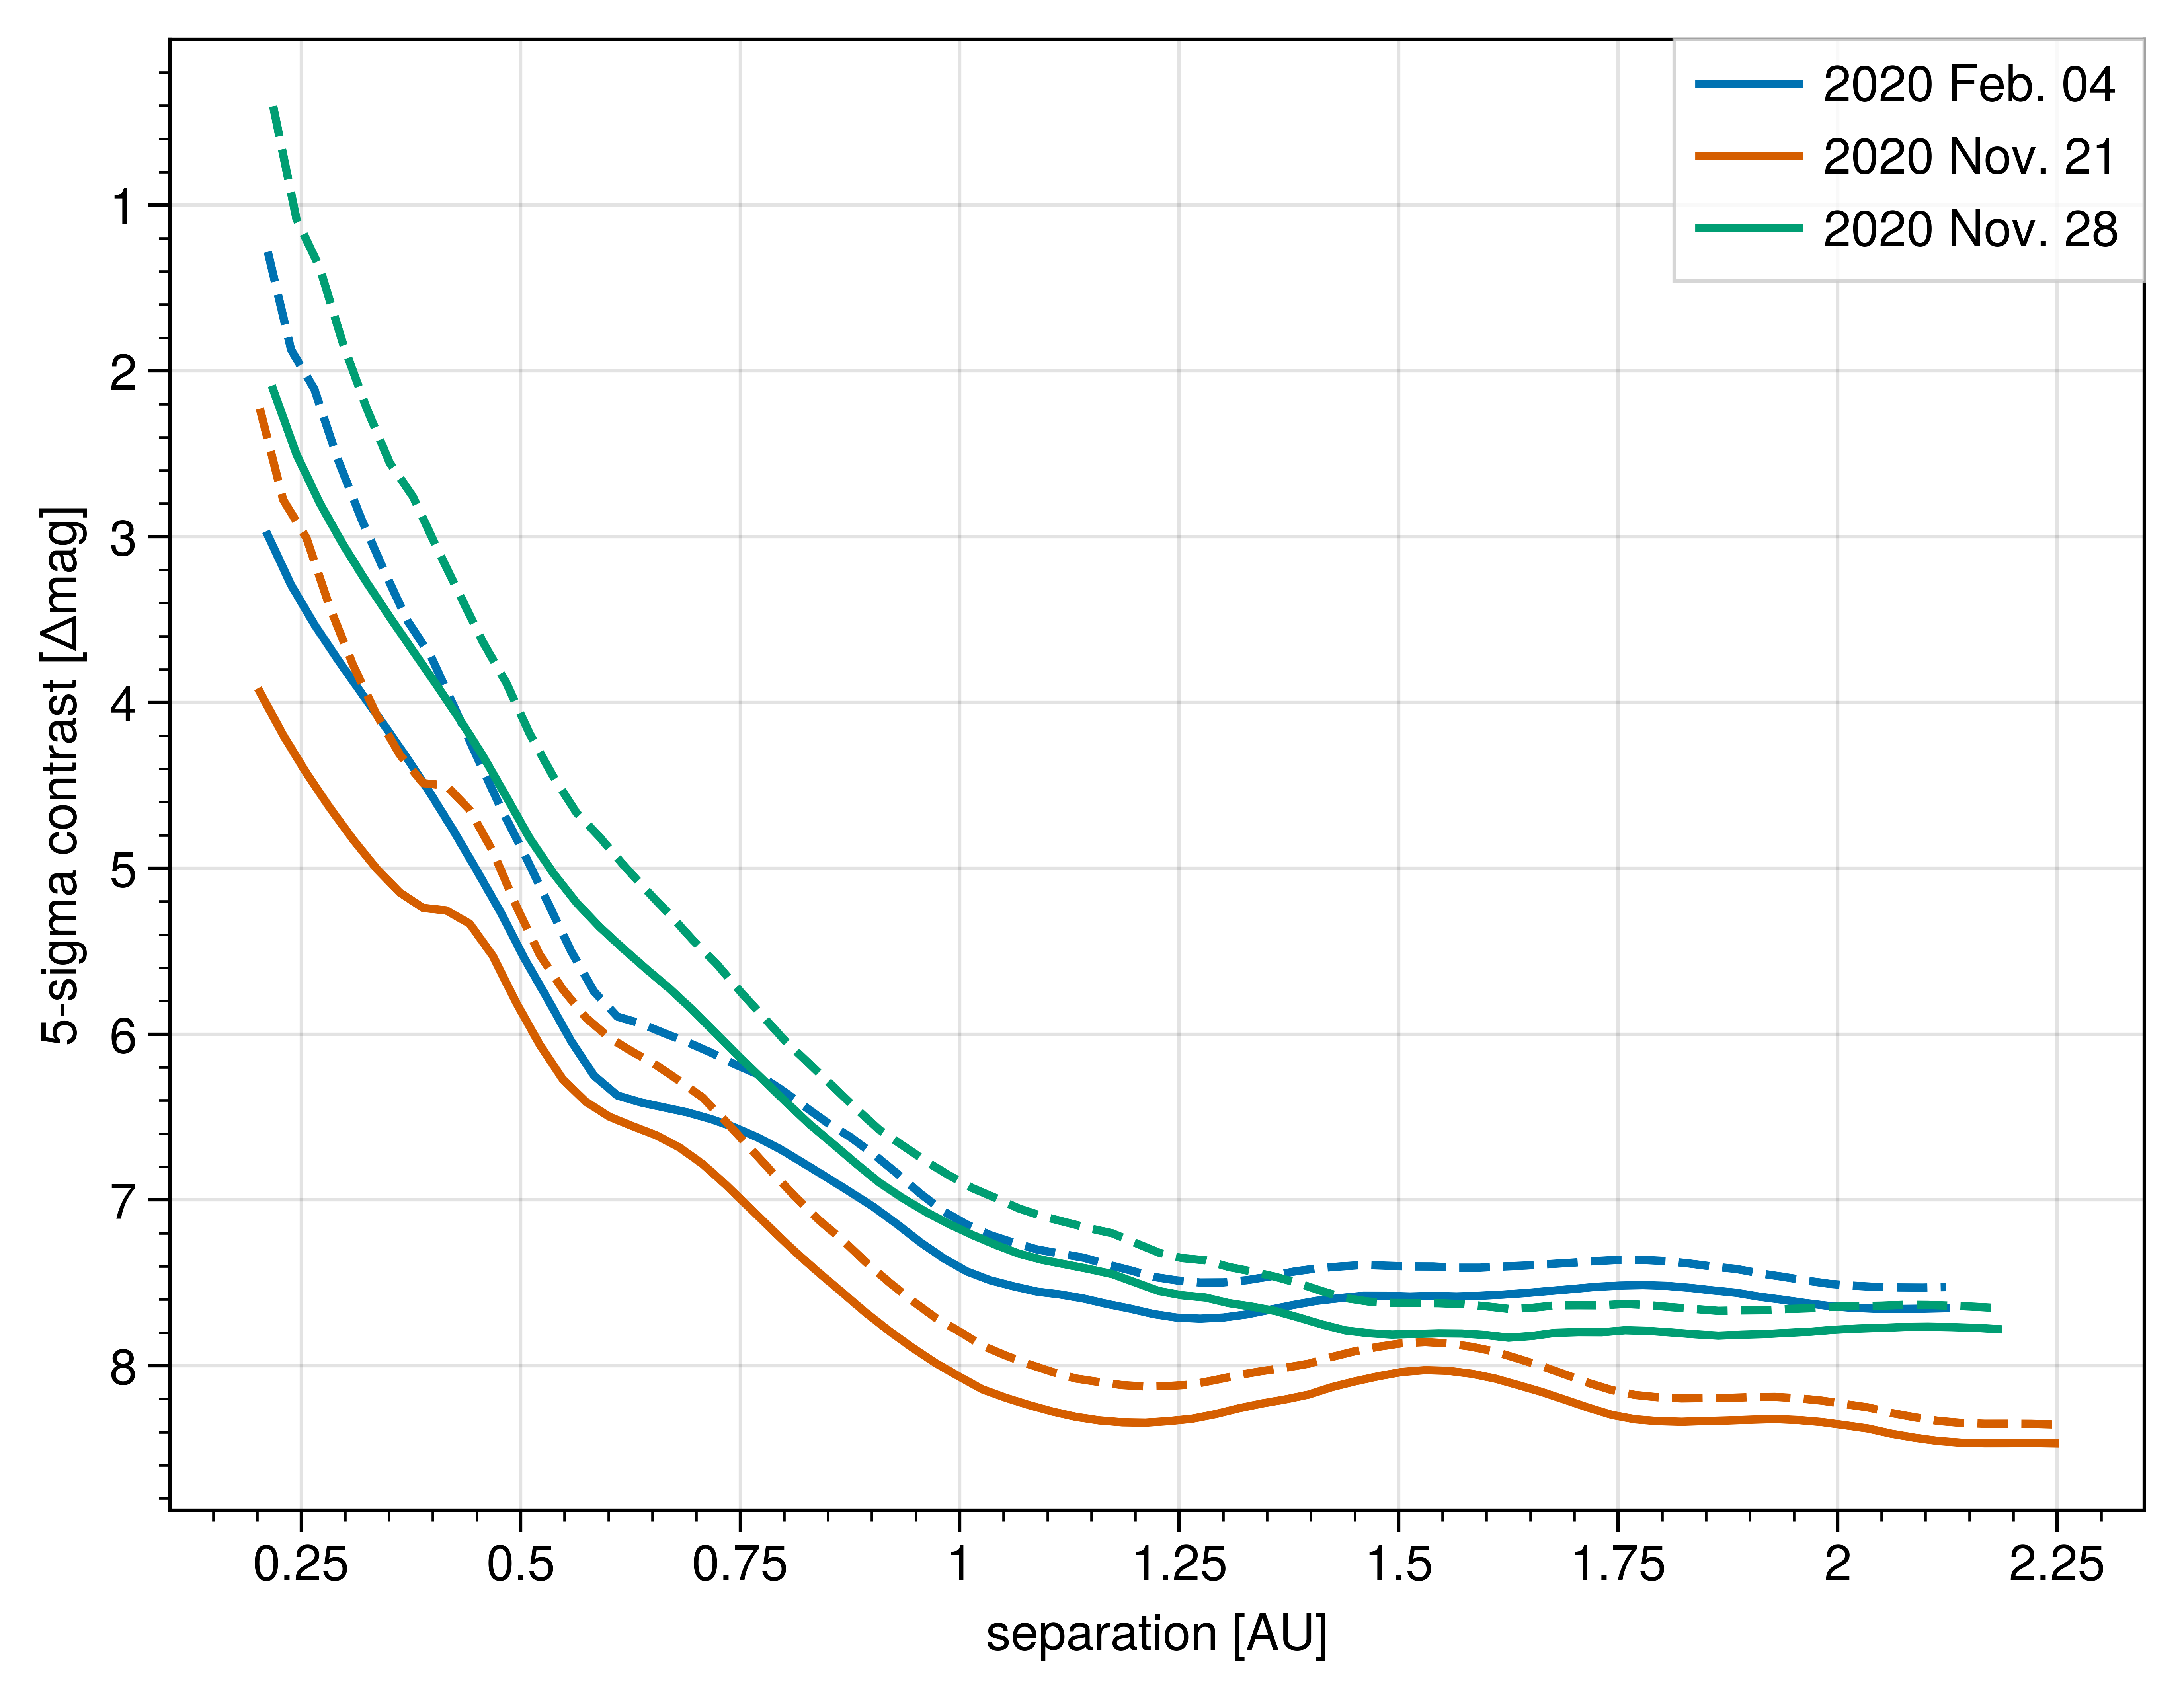

In [39]:
plot(cc_1.distance .* auscale, contrast_to_dmag.(cc_1.contrast), color="C0", label="2020 Feb. 04")
plot(cc_1.distance .* auscale, contrast_to_dmag.(cc_1.contrast_corr), color="C0", linestyle="--")

plot(cc_2.distance .* auscale, contrast_to_dmag.(cc_2.contrast), color="C1", label="2020 Nov. 21")
plot(cc_2.distance .* auscale, contrast_to_dmag.(cc_2.contrast_corr), color="C1", linestyle="--")

plot(cc_3.distance .* auscale, contrast_to_dmag.(cc_3.contrast), color="C2", label="2020 Nov. 28")
plot(cc_3.distance .* auscale, contrast_to_dmag.(cc_3.contrast_corr), color="C2", linestyle="--")

PyPlot.gca().invert_yaxis()
xlabel("separation [AU]")
ylabel("5-sigma contrast [Δmag]")
legend();

In [100]:
# calculate the mass from the contrasts

function contrast_to_mass(contrast)
    m = model.contrast_to_mass(
        deltaMag=contrast_to_dmag(contrast),
        age_Myr=age,
        band="Lp",
        dist_pc=1/parallax,
        stellar_apparent_mag=9.1
    )
end

for cc in (cc_1, cc_2, cc_3)
    cc.mass = contrast_to_mass.(cc.contrast)
    cc.mass_corr = contrast_to_mass.(cc.contrast_corr)
end

In [169]:
ms = 10.4 * log10(1.018 / 0.49) # M_sun
max_adiabatic = ms / 1.018

inner_lim = 1 * max_adiabatic * (1 - 0.14)

2.7899630517324083

In [ ]:
roche_limit(R_M=, rho_M, rho_m) = R_M * cbrt(2 * rho_M / rho_m)

function roche_escape(mass)
    a_crit = roche_limit()
    # estimate MS from Wood (1992)
    M_ms = 10.4 * log(mass / 0.49) # M_sun
    a_outer = a_crit * mass / M_ms
end

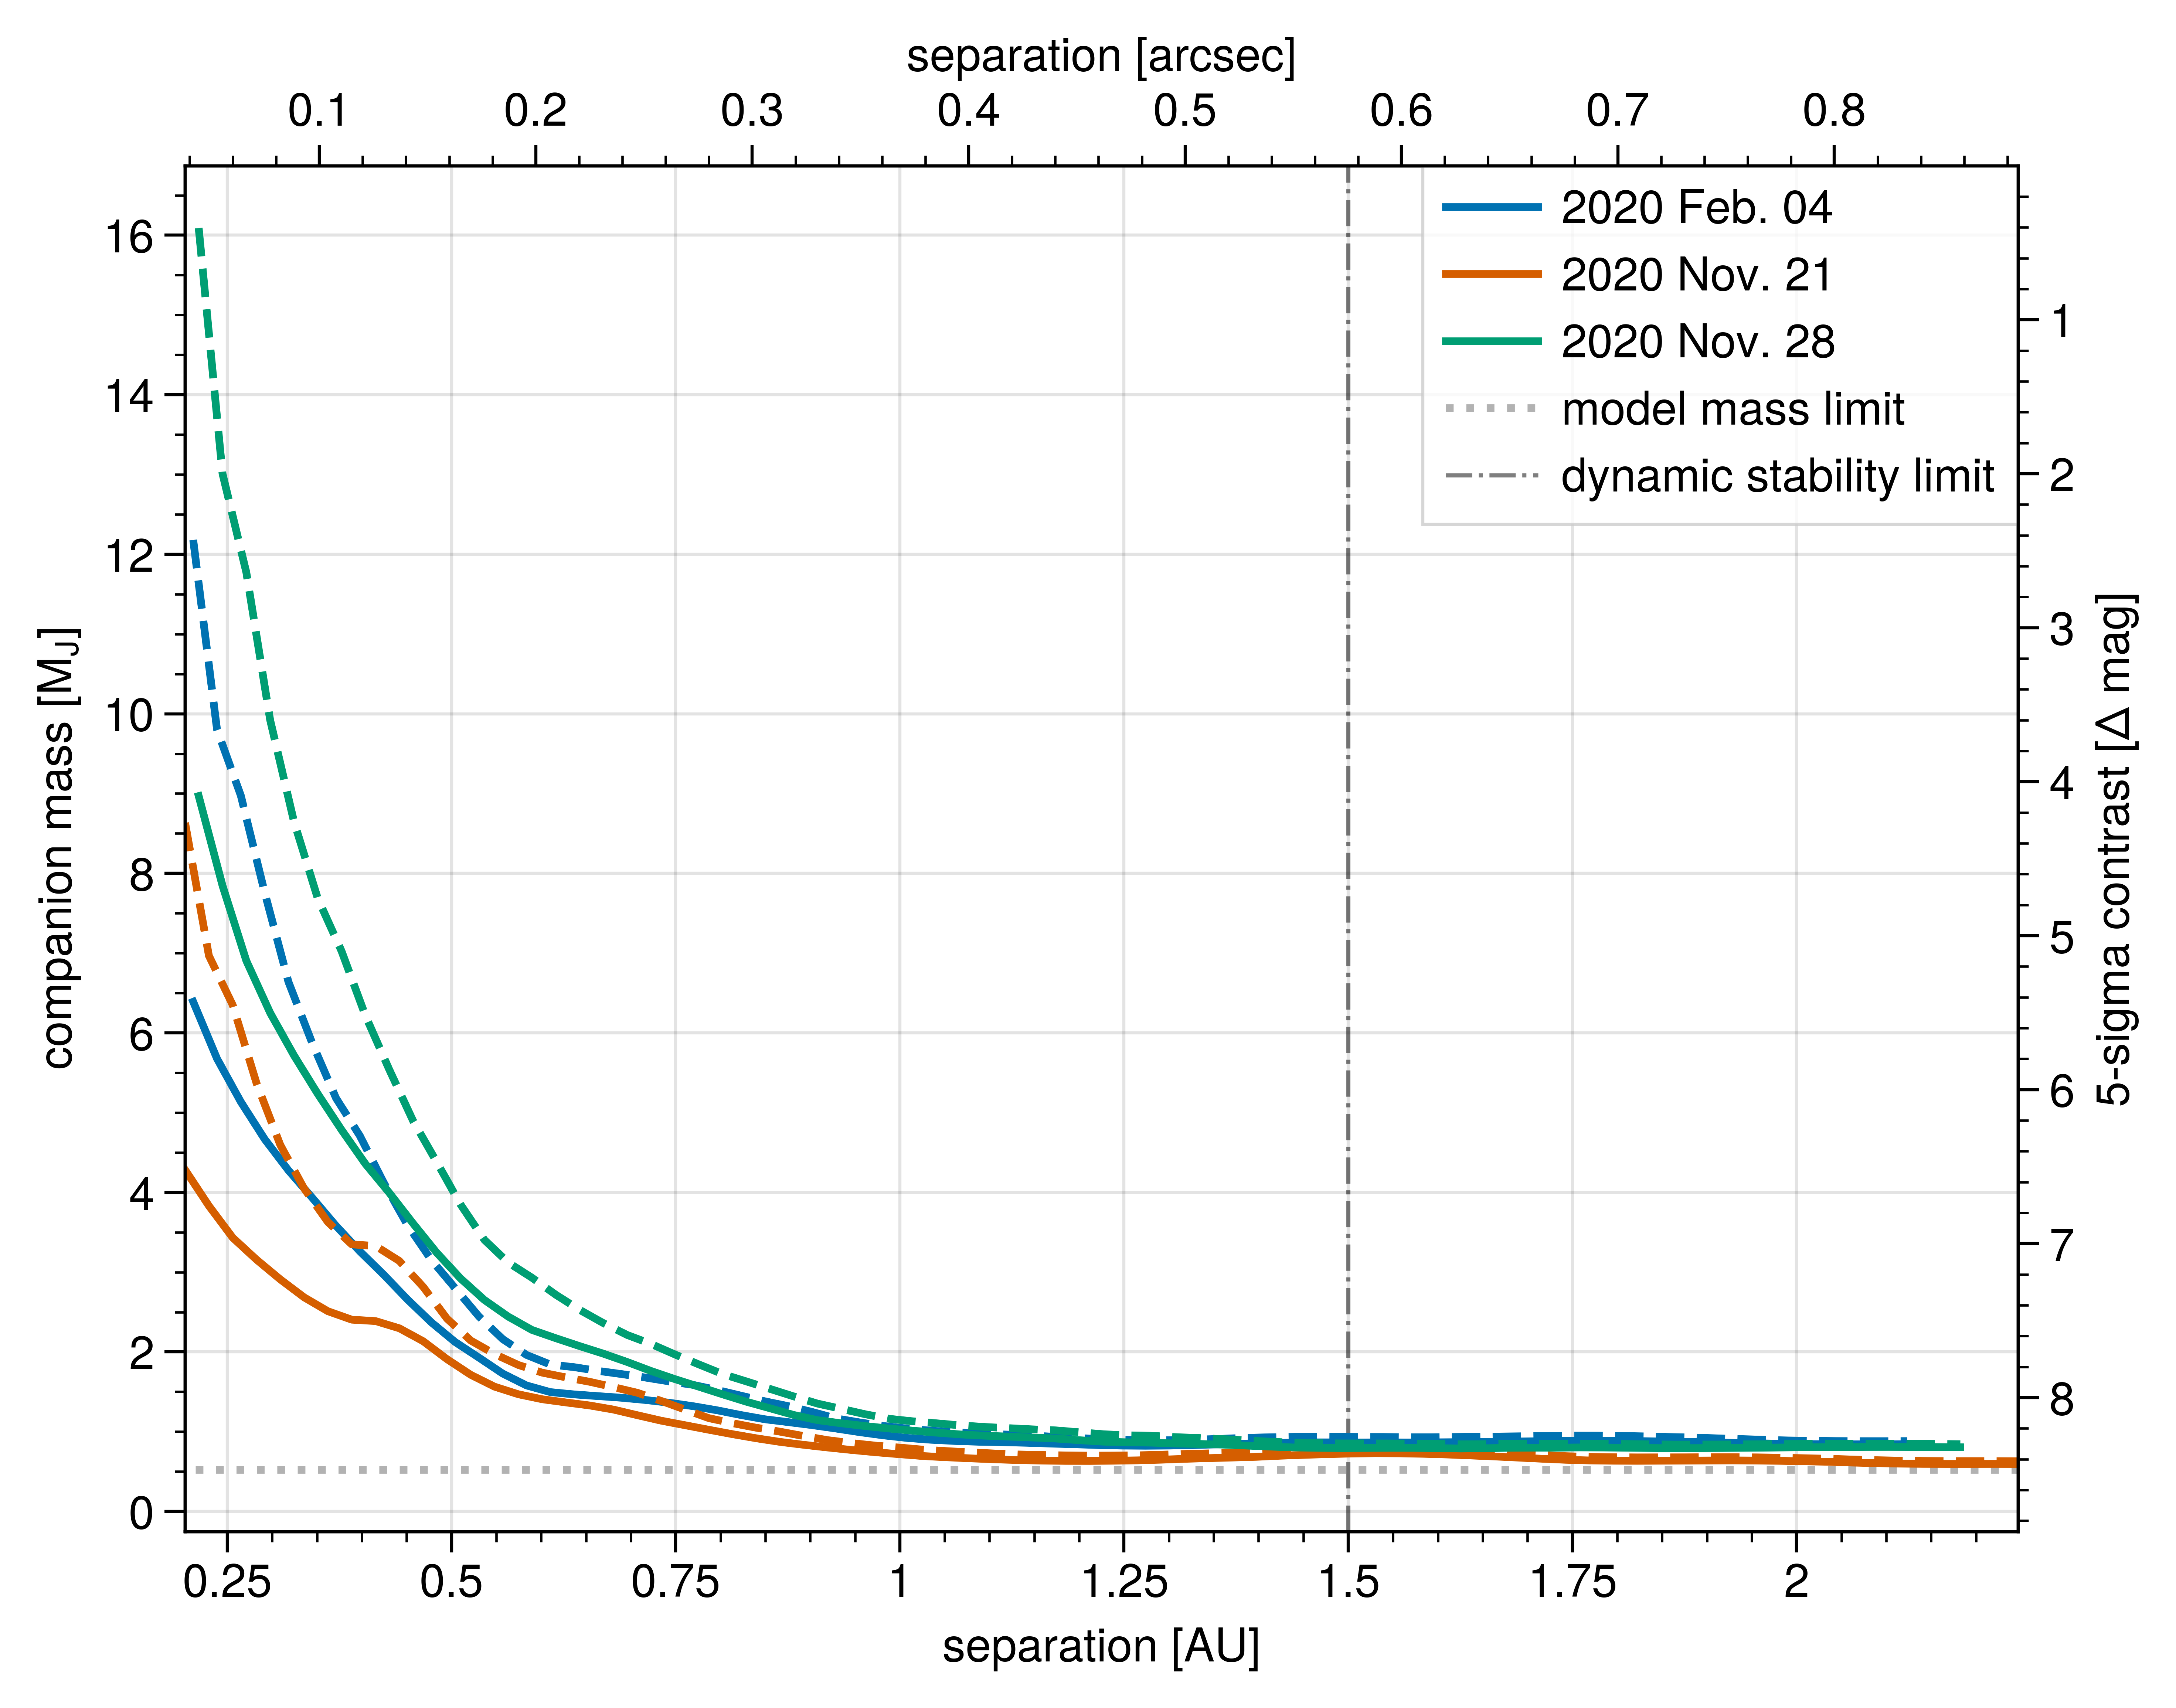

In [161]:
plot(cc_1.distance .* auscale, cc_1.mass, color="C0", label="2020 Feb. 04")
plot(cc_1.distance .* auscale, cc_1.mass_corr, color="C0", linestyle="--")
# fill_between(cc_1.distance .* auscale, cc_1.mass, cc_1.mass_corr, color="C0", alpha=0.1)

plot(cc_2.distance .* auscale, cc_2.mass, color="C1", label="2020 Nov. 21")
plot(cc_2.distance .* auscale, cc_2.mass_corr, color="C1", linestyle="--")
# fill_between(cc_2.distance .* auscale, cc_2.mass, cc_2.mass_corr, color="C1", alpha=0.1)

plot(cc_3.distance .* auscale, cc_3.mass, color="C2", label="2020 Nov. 28")
plot(cc_3.distance .* auscale, cc_3.mass_corr, color="C2", linestyle="--")
# fill_between(cc_3.distance .* auscale, cc_3.mass, cc_3.mass_corr, color="C2", alpha=0.1)

# ylim(0.005 * 1047.9, nothing) # minimum COND mass
xlims = xlim()
hlines(0.0005 * 1047.9, xlims..., color="k", alpha=0.3, linestyle=":", label="model mass limit")
xlim(extrema(cc_2.distance) .* auscale)

# yscale("log")

ylims = ylim()
vlines(1.5, ylims..., color="k", alpha=0.5, lw=0.8, linestyle="-.", label="dynamic stability limit")
ylim(ylims)
xlabel("separation [AU]")
ylabel("companion mass [" * L"M_J" * "]")
legend()
ax1 = PyPlot.gca()

###

ax2 = ax1.twinx()
plot(cc_1.distance .* auscale, contrast_to_dmag.(cc_1.contrast), alpha=0)
plot(cc_1.distance .* auscale, contrast_to_dmag.(cc_1.contrast_corr), alpha=0)

plot(cc_2.distance .* auscale, contrast_to_dmag.(cc_2.contrast), alpha=0)
plot(cc_2.distance .* auscale, contrast_to_dmag.(cc_2.contrast_corr), alpha=0)

plot(cc_3.distance .* auscale, contrast_to_dmag.(cc_3.contrast), alpha=0)
plot(cc_3.distance .* auscale, contrast_to_dmag.(cc_3.contrast_corr), alpha=0)
ylabel("5-sigma contrast [Δ mag]")
ax2.invert_yaxis()
grid(false)

### 

ax3 = ax1.twiny()
plot(cc_1.distance .* pxscale, contrast_to_dmag.(cc_1.contrast), alpha=0)
plot(cc_1.distance .* pxscale, contrast_to_dmag.(cc_1.contrast_corr), alpha=0)

plot(cc_2.distance .* pxscale, contrast_to_dmag.(cc_2.contrast), alpha=0)
plot(cc_2.distance .* pxscale, contrast_to_dmag.(cc_2.contrast_corr), alpha=0)

plot(cc_3.distance .* pxscale, contrast_to_dmag.(cc_3.contrast), alpha=0)
plot(cc_3.distance .* pxscale, contrast_to_dmag.(cc_3.contrast_corr), alpha=0)


grid(false)
xlabel("separation [arcsec]");

In [172]:
@. round([0.25, 0.5,0.75, 1, 1.5, 2] * parallax, digits=2)

6-element Vector{Float64}:
 0.09
 0.19
 0.28
 0.38
 0.57
 0.75

In [175]:
ms = extrapolate(interpolate((cc_2.distance .* auscale,), cc_2.mass, Gridded(Linear())), Flat()).([0.25, 0.5,0.75, 1, 1.5, 2])
round.(ms, sigdigits=2)

6-element Vector{Float64}:
 3.5
 1.9
 1.1
 0.72
 0.73
 0.63

In [114]:
using Interpolations
using Statistics

In [112]:
best_dist = argmax(v -> maximum(v) - minimum(v), (cc_1.distance, cc_2.distance, cc_3.distance))

cc_1_itp = extrapolate(interpolate((cc_1.distance,), cc_1.mass, Gridded(Linear())), Flat()).(best_dist)
cc_2_itp = extrapolate(interpolate((cc_2.distance,), cc_2.mass, Gridded(Linear())), Flat()).(best_dist)
cc_3_itp = extrapolate(interpolate((cc_3.distance,), cc_3.mass, Gridded(Linear())), Flat()).(best_dist)

cc_1_corr_itp = extrapolate(interpolate((cc_1.distance,), cc_1.mass_corr, Gridded(Linear())), Flat()).(best_dist)
cc_2_corr_itp = extrapolate(interpolate((cc_2.distance,), cc_2.mass_corr, Gridded(Linear())), Flat()).(best_dist)
cc_3_corr_itp = extrapolate(interpolate((cc_3.distance,), cc_3.mass_corr, Gridded(Linear())), Flat()).(best_dist);

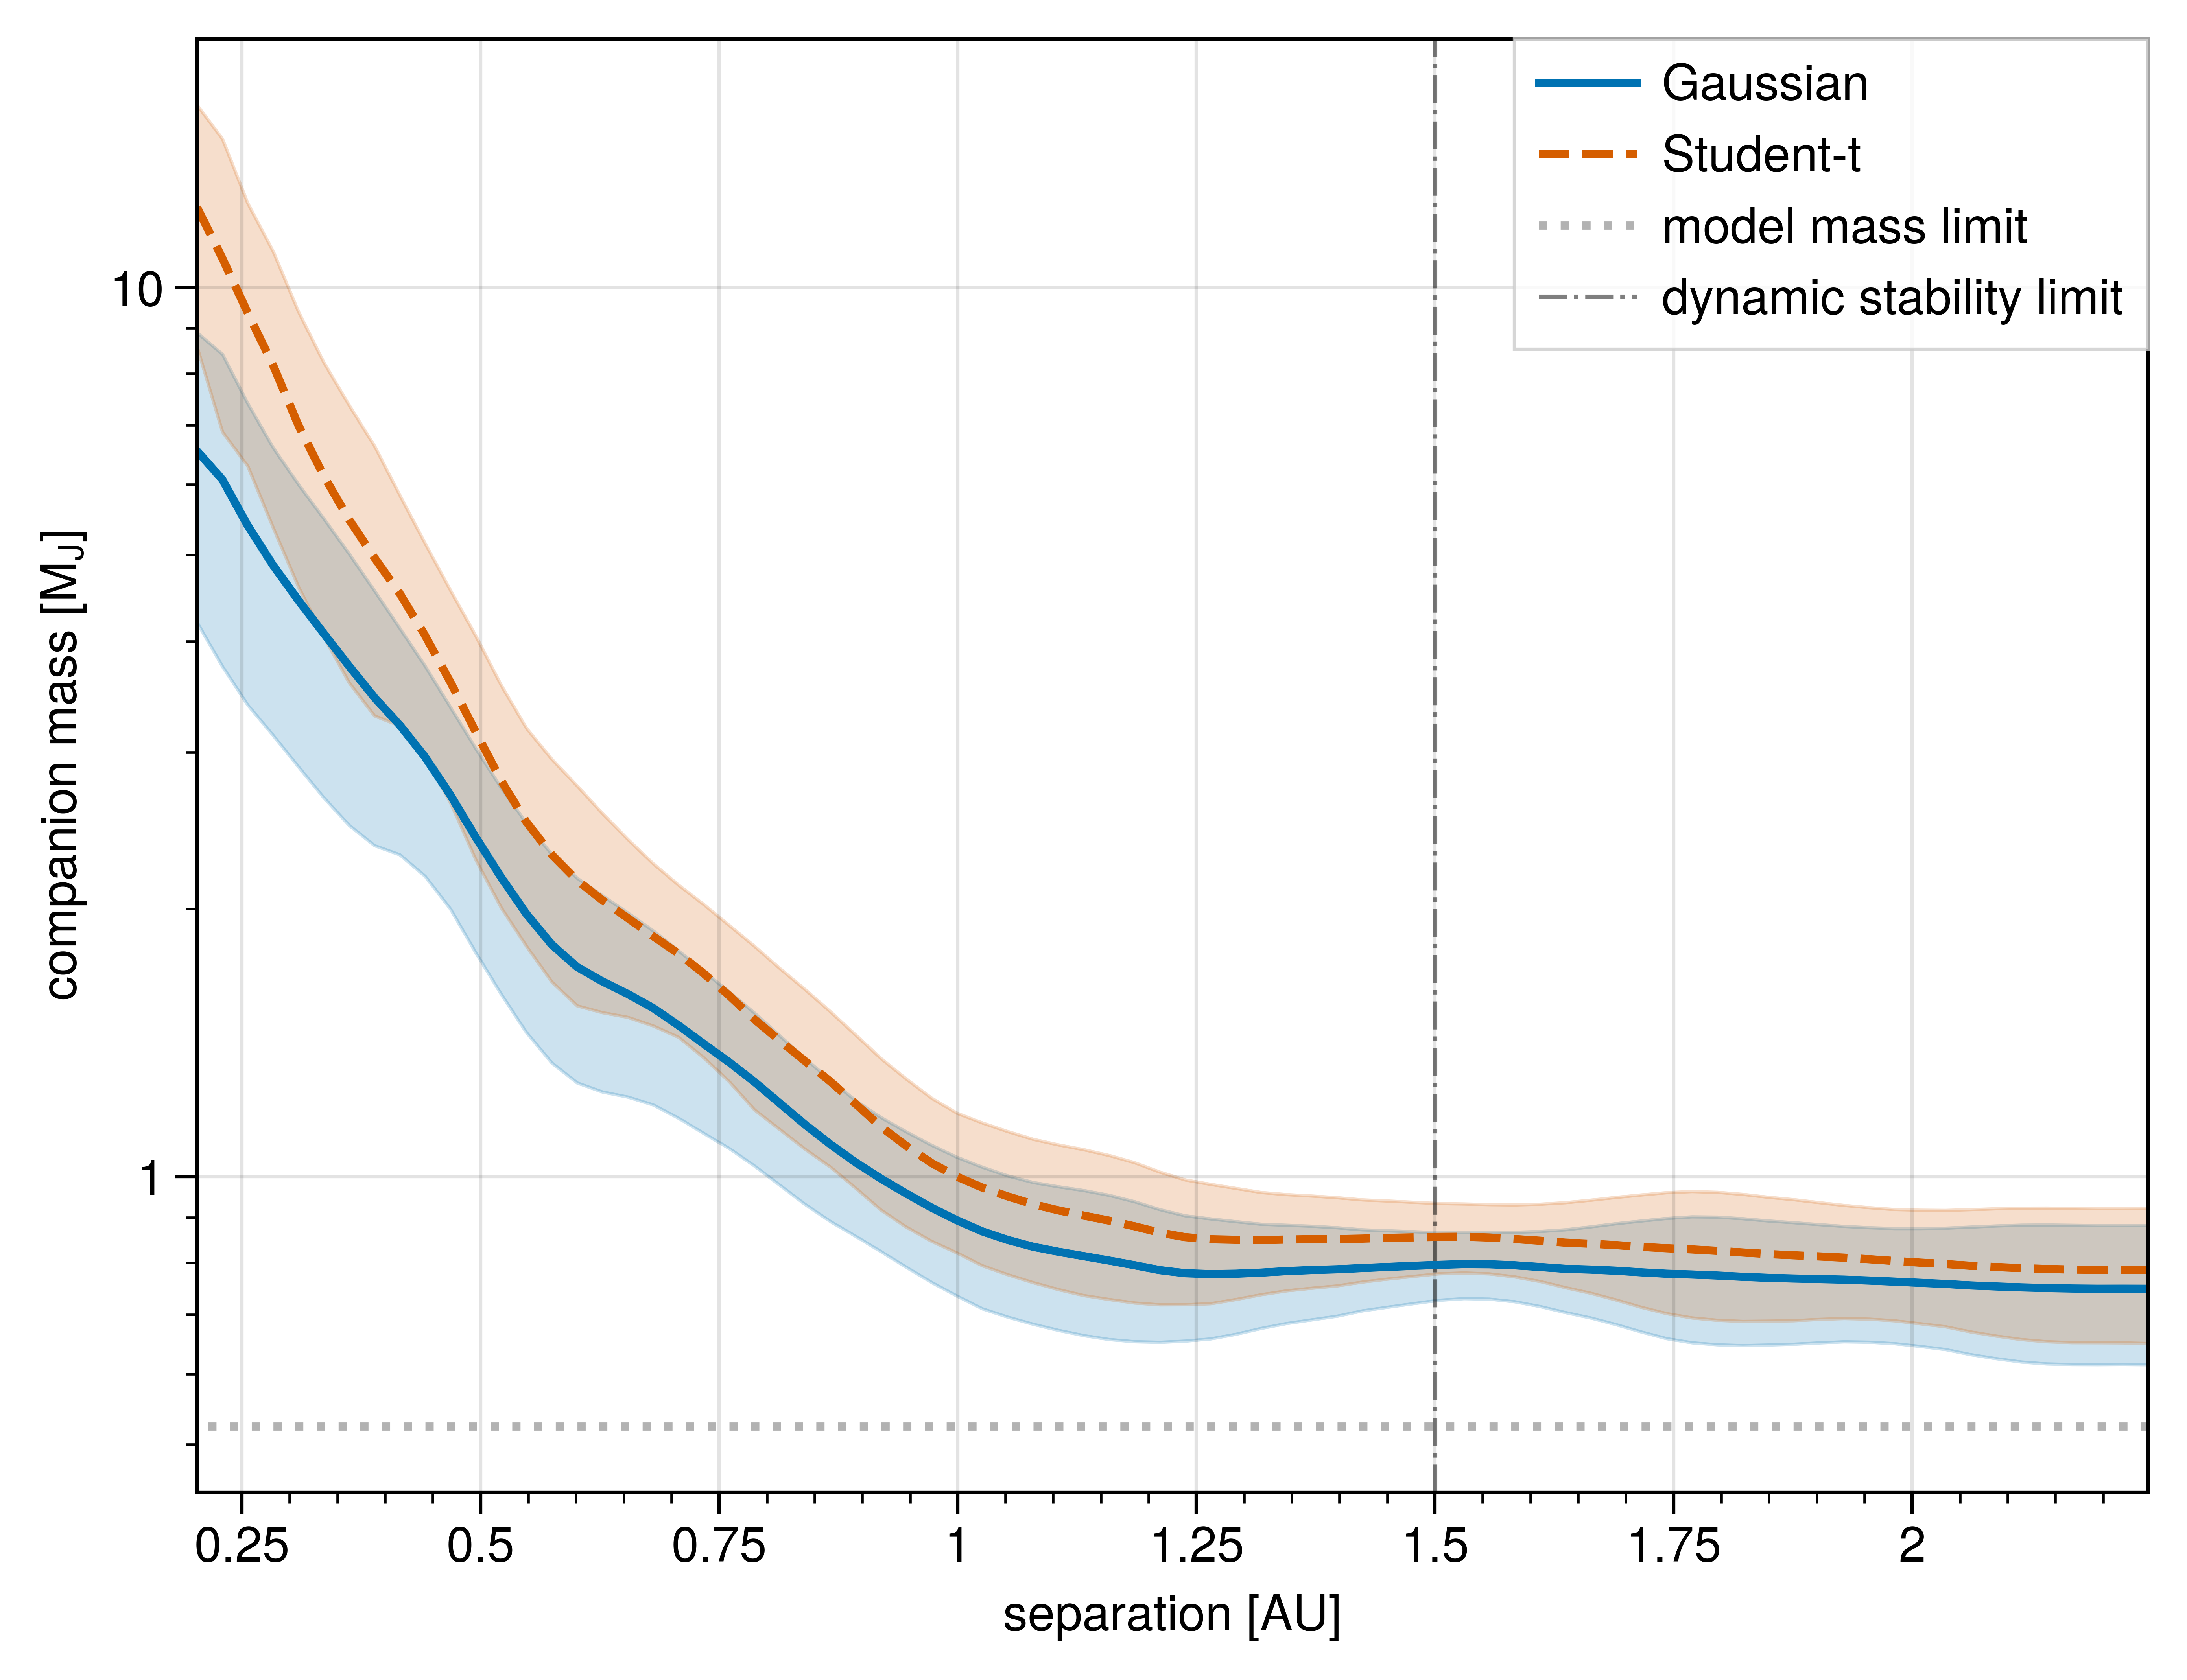

In [140]:
curve_1 = mean([cc_1_itp cc_2_itp cc_3_itp], dims=2)
sd_1 = std([cc_1_itp cc_2_itp cc_3_itp], mean=curve_1, dims=2) |> vec
curve_2 = mean([cc_1_corr_itp cc_2_corr_itp cc_3_corr_itp], dims=2)
sd_2 = std([cc_1_corr_itp cc_2_corr_itp cc_3_corr_itp], mean=curve_2, dims=2) |> vec
curve_1 = vec(curve_1)
curve_2 = vec(curve_2)

plot(best_dist .* auscale, curve_1, color="C0", label="Gaussian")
plot(best_dist .* auscale, curve_2, color="C1", label="Student-t", linestyle="--")
fill_between(best_dist .* auscale, curve_1 .- sd_1, curve_1 .+ sd_1, color="C0", alpha=0.2)
fill_between(best_dist .* auscale, curve_2 .- sd_2, curve_2 .+ sd_2, color="C1", alpha=0.2)

# ylim(0.005 * 1047.9, nothing) # minimum COND mass
xlims = xlim()
hlines(0.0005 * 1047.9, xlims..., color="k", alpha=0.3, linestyle=":", label="model mass limit")
xlim(extrema(best_dist) .* auscale)

yscale("log")

ylims = ylim()
vlines(1.5, ylims..., color="k", alpha=0.5, lw=0.8, linestyle="-.", label="dynamic stability limit")
ylim(ylims)
yscale("log")
xlabel("separation [AU]")
ylabel("companion mass [" * L"M_J" * "]")
legend();